# Imports

In [8]:
import random
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Value-Iteration

Value iteration is how we can find the optimal value function using dynamic programming for all states s $\in$ S

In [9]:
def frozen_lake(seed): #@save
    import gymnasium
    
    env = gymnasium.make("FrozenLake-v1", is_slippery=False)
    env.reset(seed=seed)  
    env.action_space.seed(seed) 
    
    unwrapped_env = env.unwrapped
    
    env_info = {}
    env_info['desc'] = unwrapped_env.desc  
    env_info['num_states'] = env.observation_space.n
    env_info['num_actions'] = env.action_space.n
    # Define indices for (transition probability, nextstate, reward, done) tuple
    env_info['trans_prob_idx'] = 0  # Index of transition probability entry
    env_info['nextstate_idx'] = 1  # Index of next state entry
    env_info['reward_idx'] = 2  # Index of reward entry
    env_info['done_idx'] = 3  # Index of done entry
    env_info['mdp'] = {}
    env_info['env'] = env  # Keep wrapped env for actual use

    for (s, others) in unwrapped_env.P.items():
        # others(s) = {a0: [ (p(s'|s,a0), s', reward, done),...], a1:[...], ...}

        for (a, pxrds) in others.items():
            # pxrds is [(p1,next1,r1,d1),(p2,next2,r2,d2),..].
            # e.g. [(0.3, 0, 0, False), (0.3, 0, 0, False), (0.3, 4, 1, False)]
            env_info['mdp'][(s,a)] = pxrds
    
    return env_info

In [10]:
def make_env(name ='', seed=0): #@save
    # Input parameters:
    # name: specifies a gym environment.
    # For Value iteration, only FrozenLake-v1 is supported.
    if name == 'FrozenLake-v1':
        return frozen_lake(seed)

    else:
        raise ValueError("%s env is not supported in this Notebook")

In [11]:
seed = 0
gamma = 0.95
num_iters = 10
random.seed(seed)
np.random.seed(seed)

In [12]:
env_info = make_env('FrozenLake-v1', seed)

In [13]:
def show_value_function_progress(env_desc, V, pi): #@save
    # This function visualizes how value and policy changes over time.
    # V: [num_iters, num_states]
    # pi: [num_iters, num_states]
    # How to visualize value function is adapted (but changed) from: https://sites.google.com/view/deep-rl-bootcamp/labs

    num_iters = V.shape[0]
    fig, ax  = plt.subplots(figsize=(15, 15))

    for k in range(V.shape[0]):
        plt.subplot(4, 4, k + 1)
        plt.imshow(V[k].reshape(4,4), cmap="bone")
        ax = plt.gca()
        ax.set_xticks(np.arange(0, 5)-.5, minor=True)
        ax.set_yticks(np.arange(0, 5)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        ax.set_yticks([])

        # LEFT action: 0, DOWN action: 1
        # RIGHT action: 2, UP action: 3
        action2dxdy = {0:(-.25, 0),1: (0, .25),
                       2:(0.25, 0),3: (-.25, 0)}

        for y in range(4):
            for x in range(4):
                action = pi[k].reshape(4,4)[y, x]
                dx, dy = action2dxdy[action]

                if env_desc[y,x].decode() == 'H':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="y",
                         size=20, fontweight='bold')

                elif env_desc[y,x].decode() == 'G':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="w",
                         size=20, fontweight='bold')

                else:
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="g",
                         size=15, fontweight='bold')

                # No arrow for cells with G and H labels
                if env_desc[y,x].decode() != 'G' and env_desc[y,x].decode() != 'H':
                    ax.arrow(x, y, dx, dy, color='r', head_width=0.2, head_length=0.15)

        ax.set_title("Step = "  + str(k + 1), fontsize=20)

    fig.tight_layout()
    plt.show()

Calculate $\sum_{s'} p(s'\mid s,a) [r + \gamma v_k(s')]$ and mdp(s,a): $[(p1,next1,r1,d1),(p2,next2,r2,d2),..]$

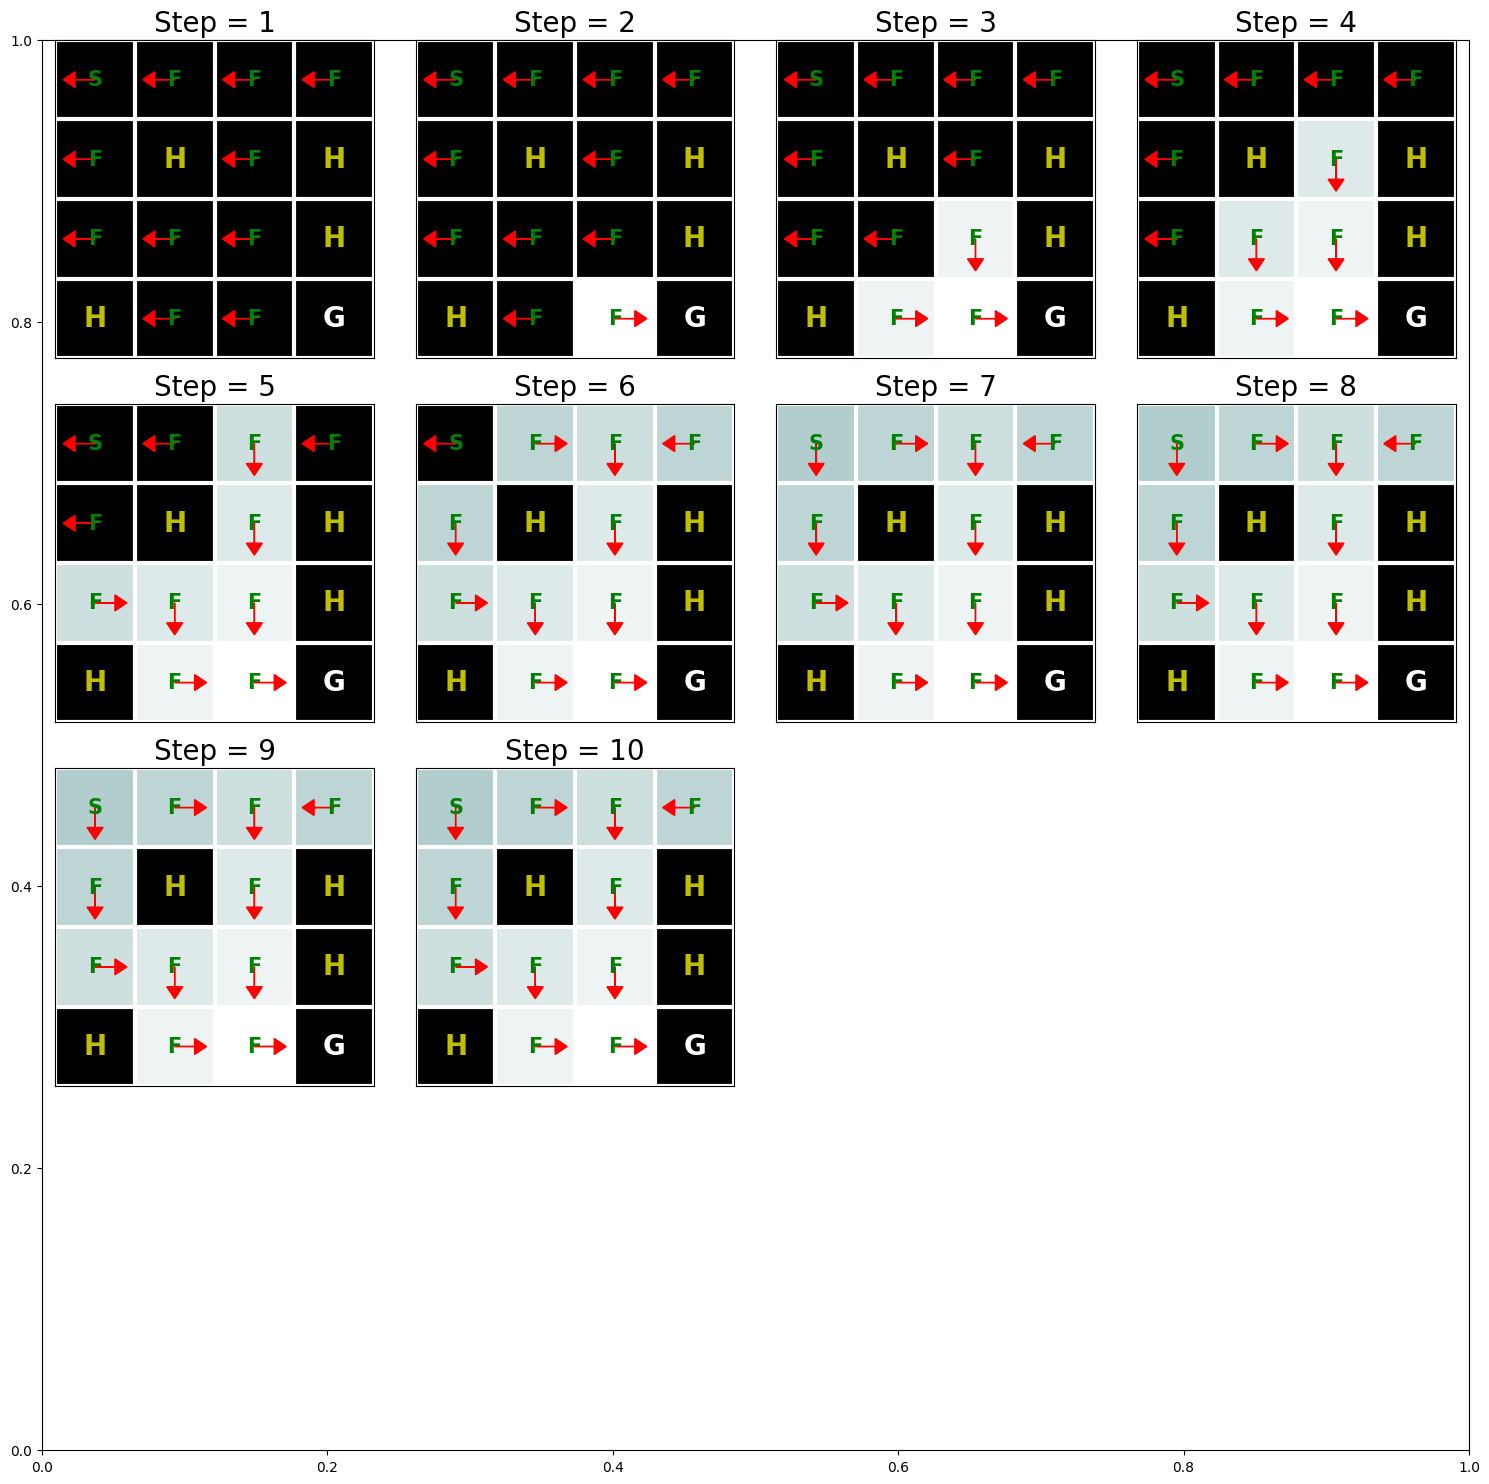

In [14]:
def value_iteration(env_info, gamma, num_iters):
    env_desc = env_info['desc']  # 2D array shows what each item means
    prob_idx = env_info['trans_prob_idx']
    nextstate_idx = env_info['nextstate_idx']
    reward_idx = env_info['reward_idx']
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']
    mdp = env_info['mdp']

    V  = np.zeros((num_iters + 1, num_states))
    Q  = np.zeros((num_iters + 1, num_states, num_actions))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        for s in range(num_states):
            for a in range(num_actions):
                # Calculate $\sum_{s'} p(s'\mid s,a) [r + \gamma v_k(s')]$
                for pxrds in mdp[(s,a)]:
                    # mdp(s,a): [(p1,next1,r1,d1),(p2,next2,r2,d2),..]
                    pr = pxrds[prob_idx]  # p(s'\mid s,a)
                    nextstate = pxrds[nextstate_idx]  # Next state
                    reward = pxrds[reward_idx]  # Reward
                    Q[k,s,a] += pr * (reward + gamma * V[k - 1, nextstate])
            # Record max value and max action
            V[k,s] = np.max(Q[k,s,:])
            pi[k,s] = np.argmax(Q[k,s,:])
    show_value_function_progress(env_desc, V[:-1], pi[:-1])

value_iteration(env_info=env_info, gamma=gamma, num_iters=num_iters)

# Q-Learning

In [15]:
seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 256  # Number of iterations
alpha   = 0.9  # Learing rate
epsilon = 0.9  # Epsilon in epsilion gready algorithm
random.seed(seed)  # Set the random seed
np.random.seed(seed)

# Now set up the environment
env_info = make_env('FrozenLake-v1', seed=seed)

In [16]:
def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()

    else:
        return np.argmax(Q[s,:])

In [20]:
def show_Q_function_progress(env_desc, V_all, pi_all): #@save
    # This function visualizes how value and policy changes over time.
    # V: [num_iters, num_states]
    # pi: [num_iters, num_states]

    # We want to only shows few values
    num_iters_all = V_all.shape[0]
    num_iters = num_iters_all // 10

    vis_indx = np.arange(0, num_iters_all, num_iters).tolist()
    vis_indx.append(num_iters_all - 1)
    V = np.zeros((len(vis_indx), V_all.shape[1]))
    pi = np.zeros((len(vis_indx), V_all.shape[1]))

    for c, i in enumerate(vis_indx):
        V[c]  = V_all[i]
        pi[c] = pi_all[i]

    num_iters = V.shape[0]
    fig, ax = plt.subplots(figsize=(15, 15))

    for k in range(V.shape[0]):
        plt.subplot(4, 4, k + 1)
        plt.imshow(V[k].reshape(4,4), cmap="bone")
        ax = plt.gca()
        ax.set_xticks(np.arange(0, 5)-.5, minor=True)
        ax.set_yticks(np.arange(0, 5)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        ax.set_yticks([])

        # LEFT action: 0, DOWN action: 1
        # RIGHT action: 2, UP action: 3
        action2dxdy = {0:(-.25, 0),1:(0, .25),
                       2:(0.25, 0),3:(-.25, 0)}

        for y in range(4):
            for x in range(4):
                action = pi[k].reshape(4,4)[y, x]
                dx, dy = action2dxdy[action]

                if env_desc[y,x].decode() == 'H':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="y",
                         size=20, fontweight='bold')

                elif env_desc[y,x].decode() == 'G':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="w",
                         size=20, fontweight='bold')

                else:
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="g",
                         size=15, fontweight='bold')

                # No arrow for cells with G and H labels
                if env_desc[y,x].decode() != 'G' and env_desc[y,x].decode() != 'H':
                    ax.arrow(x, y, dx, dy, color='r', head_width=0.2, head_length=0.15)

        ax.set_title("Step = "  + str(vis_indx[k] + 1), fontsize=20)

    fig.tight_layout()
    plt.show()

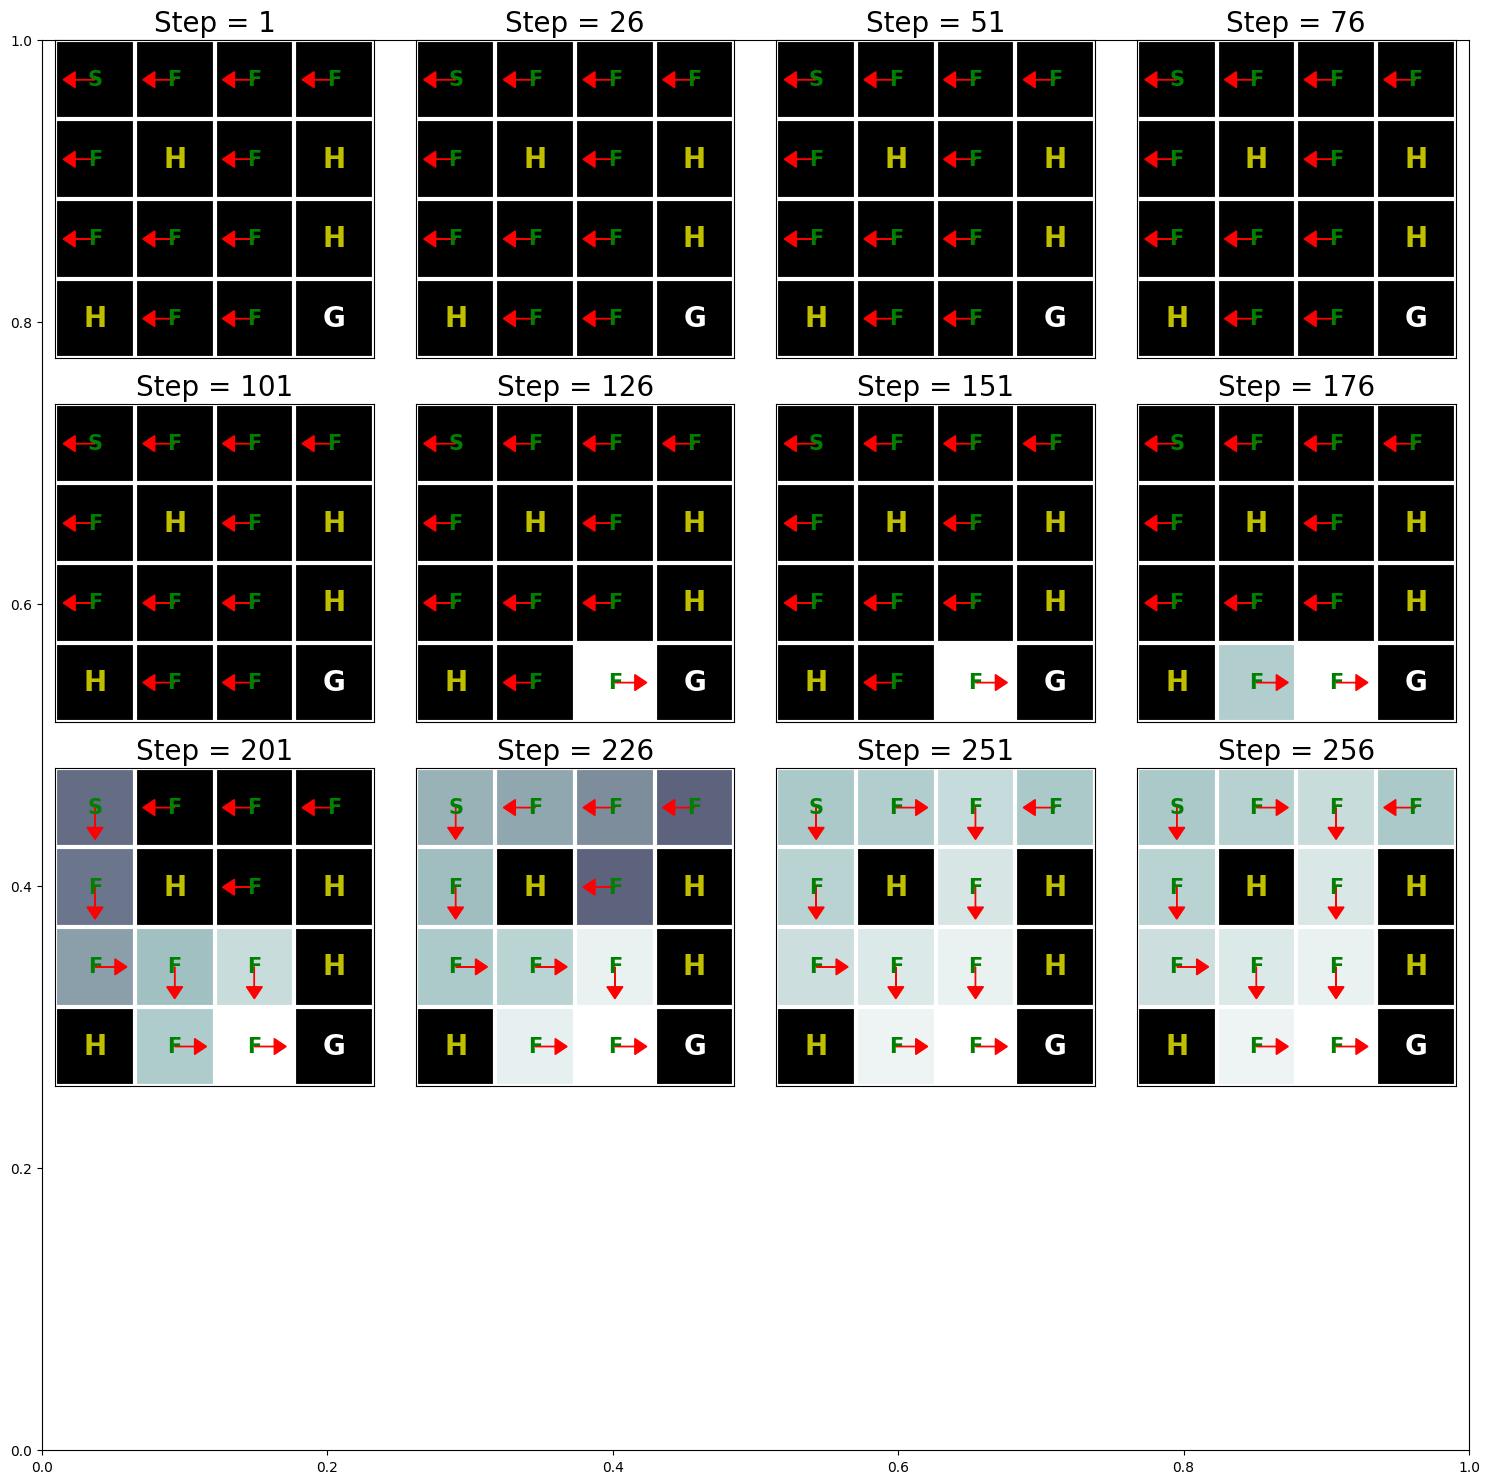

In [21]:
def q_learning(env_info, gamma, num_iters, alpha, epsilon):
    env_desc = env_info['desc']  # 2D array specifying what each grid item means
    env = env_info['env']  # 2D array specifying what each grid item means
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']

    Q  = np.zeros((num_states, num_actions))
    V  = np.zeros((num_iters + 1, num_states))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        # Reset environment
        state, _ = env.reset()
        done = False
        while not done:
            # Select an action for a given state and acts in env based on selected action
            action = e_greedy(env, Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-update:
            y = reward + gamma * np.max(Q[next_state,:])
            Q[state, action] = Q[state, action] + alpha * (y - Q[state, action])

            # Move to the next state
            state = next_state
        # Record max value and max action for visualization purpose only
        for s in range(num_states):
            V[k,s]  = np.max(Q[s,:])
            pi[k,s] = np.argmax(Q[s,:])
    show_Q_function_progress(env_desc, V[:-1], pi[:-1])

q_learning(env_info=env_info, gamma=gamma, num_iters=num_iters, alpha=alpha, epsilon=epsilon)